## Setting Up
We begin by importing the necessary modules:

In [1]:
import os
import time
from tempfile import TemporaryDirectory

import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

The TemporaryDirectory class is a part of Python's tempfile library, which provides a way to create temporary files and directories. In our case, it is used to store the model checkpoints during training temporarily. Once training is done, the best model is loaded and the directory is deleted.

## Preprocessing the Data
Before we can feed our dataset into a model, we need to transform it into a format that the model can understand. For this, we use the transforms module from torchvision:

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

This Normalize transformation normalizes the tensor image by subtracting the mean and dividing by the standard deviation for each of the color channels (Red, Green, and Blue). The numbers provided are the mean and standard deviation values calculated on the ImageNet dataset, which is commonly used for training deep learning models. Normalization helps improve the convergence speed and overall performance of the model.

Next, we load our dataset and split it into a training set and a validation set:

In [3]:
dataset = datasets.ImageFolder('/kaggle/input/cats-breed-dataset/cat_v1')

train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

In [4]:
dataloaders = {
    name: torch.utils.data.DataLoader(
        dataset,
        batch_size=4,
        shuffle=True,
        num_workers=4
    ) for name, dataset in zip(["train", "val"], [train_dataset, val_dataset])
}

class_names = train_dataset.dataset.classes
dataset_sizes = { name: len(dataset) for name, dataset in zip(["train", "val"], [train_dataset, val_dataset]) }
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class_names, dataset_sizes, device

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(['bengal', 'domestic_shorthair', 'maine_coon', 'ragdoll', 'siamese'],
 {'train': 761, 'val': 191},
 device(type='cuda', index=0))

## Model Training Code
The `train_model` function trains a PyTorch model for a specified number of epochs. It alternates between training and validation phases per epoch. In the training phase, the model is trained using the training data and the model's weights are updated. In the validation phase, the model's performance is evaluated on the validation data.

The function records the training and validation accuracy and losses for each epoch. The best performing model (based on validation accuracy) is saved in a temporary directory. After all epochs, the function loads the best model's parameters, prints the total training time and the best validation accuracy, and returns the best model and the recorded history.

The model training code is as follows:

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    return running_loss, running_corrects


def validate_epoch(model, dataloader, criterion, device):
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    return running_loss, running_corrects


def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        history = []

        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            train_loss, train_corrects = train_epoch(model, dataloaders['train'], criterion, optimizer, device)
            scheduler.step()
            val_loss, val_corrects = validate_epoch(model, dataloaders['val'], criterion, device)

            train_loss /= dataset_sizes['train']
            train_acc = train_corrects.double() / dataset_sizes['train']
            val_loss /= dataset_sizes['val']
            val_acc = val_corrects.double() / dataset_sizes['val']

            history.append([train_acc, val_acc, train_loss, val_loss])
            print(f'Epoch {epoch}/{num_epochs - 1}: '
                  f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

            # deep copy the model
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model, history

## Fine-Tuning the Model
The 2 major transfer learning scenarios look as follows:

- **Finetuning the ConvNet:** Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- **ConvNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained

In [6]:
model_orig = torchvision.models.convnext_base(weights='IMAGENET1K_V1')
model_orig.classifier[2] = torch.nn.Linear(
    in_features=model_orig.classifier[2].in_features,
    out_features=len(class_names)
)
model_orig = model_orig.to(device)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:10<00:00, 34.6MB/s] 


### Method 1: Fine-tuning the Entire ConvNet
This first approach involves training all the layers of the model. We start by loading a pre-trained model, replacing the final layer to match our number of output classes, and moving the model to the GPU if one is available. Next, we define the loss function, optimizer, and learning rate scheduler. We use Cross-Entropy Loss as our loss function, Stochastic Gradient Descent (SGD) as our optimizer, and a StepLR scheduler to decrease the learning rate every 6epochs:

In [7]:
model_ft = models.convnext_base(weights='IMAGENET1K_V1')
model_ft.classifier[2] = torch.nn.Linear(
    in_features=model_ft.classifier[2].in_features,
    out_features=len(class_names)
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

Finally, we train the model:

In [8]:
model_ft, model_ft_history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=13)

Epoch 0/12: Train Loss: 1.4539, Acc: 0.4639, Val Loss: 1.2863, Acc: 0.6597
Epoch 1/12: Train Loss: 1.1704, Acc: 0.7175, Val Loss: 1.0055, Acc: 0.7906
Epoch 2/12: Train Loss: 0.9552, Acc: 0.7714, Val Loss: 0.8086, Acc: 0.8010
Epoch 3/12: Train Loss: 0.7954, Acc: 0.8081, Val Loss: 0.6821, Acc: 0.8220
Epoch 4/12: Train Loss: 0.6943, Acc: 0.8173, Val Loss: 0.6297, Acc: 0.8429
Epoch 5/12: Train Loss: 0.5954, Acc: 0.8371, Val Loss: 0.5535, Acc: 0.8482
Epoch 6/12: Train Loss: 0.5381, Acc: 0.8673, Val Loss: 0.5407, Acc: 0.8534
Epoch 7/12: Train Loss: 0.5307, Acc: 0.8660, Val Loss: 0.5326, Acc: 0.8534
Epoch 8/12: Train Loss: 0.5204, Acc: 0.8686, Val Loss: 0.5285, Acc: 0.8586
Epoch 9/12: Train Loss: 0.5137, Acc: 0.8686, Val Loss: 0.5224, Acc: 0.8586
Epoch 10/12: Train Loss: 0.5110, Acc: 0.8686, Val Loss: 0.5181, Acc: 0.8534
Epoch 11/12: Train Loss: 0.5030, Acc: 0.8765, Val Loss: 0.5132, Acc: 0.8586
Epoch 12/12: Train Loss: 0.4903, Acc: 0.8817, Val Loss: 0.5127, Acc: 0.8586

Training complete in 

### Method 2: Fine-tuning Just the Head of the Model
The second approach involves training only the final layer (the “head”) of the model while freezing the rest of the network. This can be beneficial when our new task is similar to the task the model was originally trained on or when we have limited resources at our disposal. We start by loading a pre-trained model, freezing all the parameters, replacing the final layer, and moving the model to the GPU. As before, we define the loss function, optimizer, and learning rate scheduler. This time, however, the optimizer only updates the parameters of the final layer

In [9]:
model_conv = torchvision.models.convnext_base(weights='IMAGENET1K_V1')
for param in model_conv.parameters(): param.requires_grad = False
model_conv.classifier[2] = torch.nn.Linear(
    in_features=model_conv.classifier[2].in_features,
    out_features=len(class_names)
)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.classifier[2].parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=6, gamma=0.1)

Finally, we train the model:

In [10]:
model_conv, model_conv_history = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=13)

Epoch 0/12: Train Loss: 1.5239, Acc: 0.3627, Val Loss: 1.3980, Acc: 0.6911
Epoch 1/12: Train Loss: 1.3271, Acc: 0.6912, Val Loss: 1.2316, Acc: 0.7382
Epoch 2/12: Train Loss: 1.1880, Acc: 0.7543, Val Loss: 1.1057, Acc: 0.7592
Epoch 3/12: Train Loss: 1.0734, Acc: 0.7858, Val Loss: 1.0082, Acc: 0.7853
Epoch 4/12: Train Loss: 0.9988, Acc: 0.7898, Val Loss: 0.9344, Acc: 0.7906
Epoch 5/12: Train Loss: 0.9273, Acc: 0.7989, Val Loss: 0.8780, Acc: 0.7906
Epoch 6/12: Train Loss: 0.8924, Acc: 0.8042, Val Loss: 0.8726, Acc: 0.7906
Epoch 7/12: Train Loss: 0.8855, Acc: 0.8187, Val Loss: 0.8674, Acc: 0.7906
Epoch 8/12: Train Loss: 0.8836, Acc: 0.8121, Val Loss: 0.8624, Acc: 0.7906
Epoch 9/12: Train Loss: 0.8800, Acc: 0.8042, Val Loss: 0.8574, Acc: 0.7906
Epoch 10/12: Train Loss: 0.8742, Acc: 0.8121, Val Loss: 0.8525, Acc: 0.7906
Epoch 11/12: Train Loss: 0.8765, Acc: 0.7950, Val Loss: 0.8478, Acc: 0.7958
Epoch 12/12: Train Loss: 0.8706, Acc: 0.8108, Val Loss: 0.8474, Acc: 0.7958

Training complete in 

We can then compare the performance of the two approaches by plotting their training and validation accuracy over time:

In [11]:
model_ft_history = pd.DataFrame(model_ft_history, columns=["Train Accuracy", "Validation Accuracy", "Train Loss", "Validation Loss"])
model_conv_history = pd.DataFrame(model_conv_history, columns=["Train Accuracy", "Validation Accuracy", "Train Loss", "Validation Loss"])

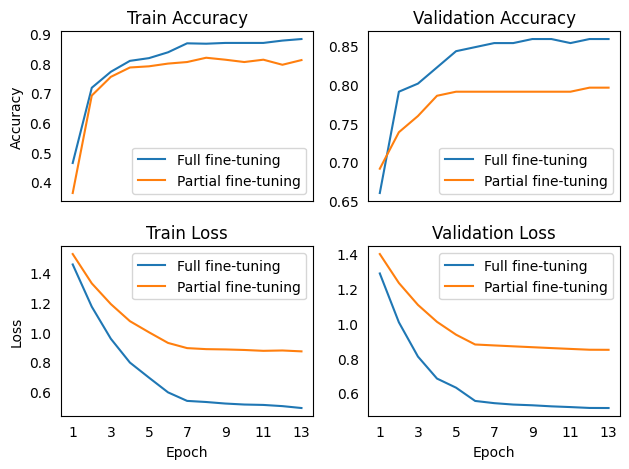

In [12]:
num_of_subplots = len(model_ft_history.columns)

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)

for i, title, ax in zip(range(num_of_subplots), model_ft_history.columns, [i for x in axs for i in x]):
    ax.plot(model_ft_history.iloc[:, i], label='Full fine-tuning')
    ax.plot(model_conv_history.iloc[:, i], label='Partial fine-tuning')
    ax.set_xticks(range(13)) 
    ax.set_xticklabels(("1", " ", "3", " ", "5", " ", "7", " ", "9", " ", "11", " ", "13"))
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    if i > 1:  ax.set_xlabel('Epoch')
    if i == 0: ax.set_ylabel('Accuracy')
    if i == 2: ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

Different scenarios might prove a different method to be more effective. Hyperparameter tuning, such finding the optimal LR or right number of epochs could definitely result in a much more accurate model!

## Inference on a real-world test image
What better image to use than an image of my own cat 🤗. I myself do not know the exact breed of the cat as its a rescue but it is thought to be a Siamese due to its short hair and color pattern.

In [13]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        model.train(mode=was_training)
        return outputs

The results from the model are as follows. The following also confirms that the model successfully learnt relevant features during training and is now much more reliable and accurate:

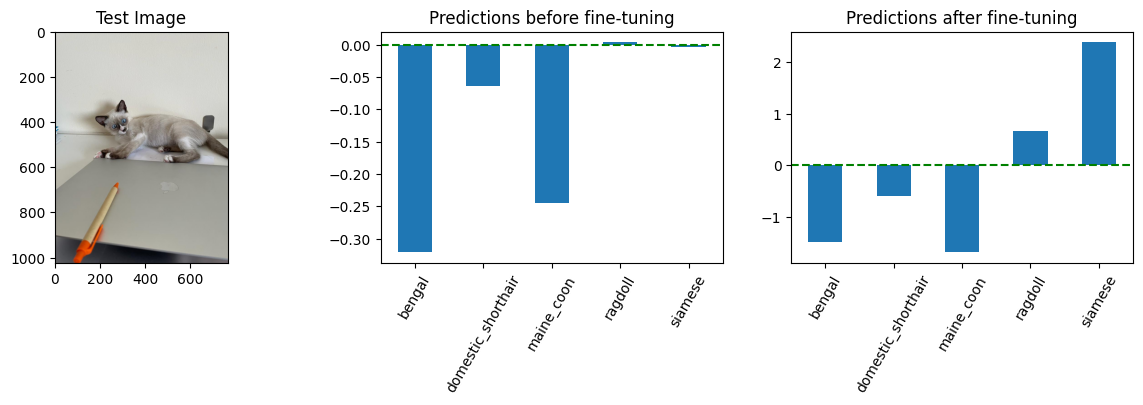

In [14]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

img = cv2.imread("/kaggle/input/model-test/cat.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax1.imshow(img)
ax1.set_title("Test Image")

original_preds = visualize_model_predictions(model_orig, "/kaggle/input/model-test/cat.jpeg")
ax2 = pd.Series(original_preds.data.cpu().numpy().tolist()[0]).plot(kind='bar', ax=ax2)
ax2.set_xticklabels(class_names, rotation=60)
ax2.axhline(y=0, color='green', linestyle='--')
ax2.set_title("Predictions before fine-tuning")

finetuned_preds = visualize_model_predictions(model_ft, "/kaggle/input/model-test/cat.jpeg")
pd.Series(finetuned_preds.data.cpu().numpy().tolist()[0]).plot(kind='bar', ax=ax3)
ax3.set_xticklabels(class_names, rotation=60)
ax3.axhline(y=0, color='green', linestyle='--')
ax3.set_title("Predictions after fine-tuning")

plt.show()

It is indeed a Siamese according to the model too!

## Conclusion
Transfer learning is a powerful technique that allows us to leverage pre-trained models, reducing the time and computational resources required to train a robust model from scratch. Fine-tuning involves adjusting the parameters of a pre-trained model to our specific task, and can be done on the entire model or just the head. This tutorial provides a practical example of how to use transfer learning for a computer vision task in PyTorch.

Happy fine-tuning!